In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"paresh501","key":"7c68df85e1c6ec47a25cfdb6fd99ddd7"}'}

In [2]:
! pip install -q kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
'chmod 600 ~/.kaggle/kaggle.json'

'chmod 600 ~/.kaggle/kaggle.json'

In [3]:
! kaggle datasets download -d andrewmvd/face-mask-detection

 97% 387M/398M [00:03<00:00, 127MB/s]
100% 398M/398M [00:03<00:00, 122MB/s]


In [ ]:
! unzip face-mask-detection.zip

In [5]:
!ls

annotations  face-mask-detection.zip  images  kaggle.json  sample_data


In [6]:
#import the libraries
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from skimage import transform

import cv2
import random as rand
from bs4 import BeautifulSoup

In [7]:
# Defining necessary function for extracting faces from image and their label

#This function will get the coordinates of face given in the annotations file
# the coordinates of lower left corner and upper right corner
def find_cordinates(obj):
    """
      This Function will take face object from XML file and
      will return four cordinates of box associated with face
    """
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]


def find_label(obj):
    """
      This Function will take face object from XML file and
      extract label for that face and return integer according to that label
      We have used following conversation:
          Without Mask : 0
          With Mask : 1
          Incorrect Mask: 2
    """
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

#Using in this main function we parse the annotations file and get the objects out from them
# Also we use the above two functions here 
def find_faces(image_number, xml_file): 
    """
        This Function will take image number and XML file as input and
        returns total number of faces in given image and 
                dictionary with following (key, value), 
                  boxes = (all tuples of four coordinates representing face)
                  labels = (label coresponding to each face)
      """
    with open(xml_file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        total_faces = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(find_cordinates(i))
            labels.append(find_label(i))
            
        boxes=np.array(boxes)
        labels=np.array(labels)

        img_id = np.array(image_number)
        #dictionary
        avail_faces = {}
        avail_faces["boxes"] = boxes
        avail_faces["labels"] = labels
        
        return (avail_faces, total_faces)

In [8]:
#Finding total number of images present in dataset
imgs = list(sorted(os.listdir("images")))
len(imgs)

853

In [9]:
#Finding total number of annotations file present in dataset
labels = list(sorted(os.listdir("annotations")))
len((labels))

853

In [10]:
# Here, we will extract faces and their corresponding label for each of the image

targets=[]  #This wil store dictionaries of faces and labels
number_of_faces=[]  #This wil store total number of faces in each image

for i in range(853):

    image_file = 'maksssksksss'+ str(i) + '.png'
    xml_file = 'maksssksksss'+ str(i) + '.xml'
    
    img_path = os.path.join("images", image_file)
    label_path = os.path.join("annotations", xml_file)
    
    #Finding faces and their coordinates
    target, numobj = find_faces(i, label_path)
    targets.append(target)
    number_of_faces.append(numobj)

In [11]:
#Here we will crop faces from images and store faces and their labels in array
face_images=[]
face_labels=[]

for i in range(853):
    img_path = r"images/maksssksksss{}.png".format(i)
    #read image
    img = cv2.imread(img_path)

    for j in range(number_of_faces[i]):

        #Get location of four coordinates
        locs=(targets[i]['boxes'][j])

        img1=img[locs[1]:locs[3],locs[0]:locs[2]]

        #Resizing and preprocessing
        img1 = cv2.resize(img1, (224, 224))
        img1 = img_to_array(img1)
        img1 = preprocess_input(img1)
        
        face_images.append(img1)
        face_labels.append(targets[i]['labels'][j])

face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)

In [12]:
face_images= np.array(face_images, dtype="float32")/255.0

In [13]:
#Finding Total number of faces across all images
len(face_labels)

4072

{0: 717, 1: 3232, 2: 123}


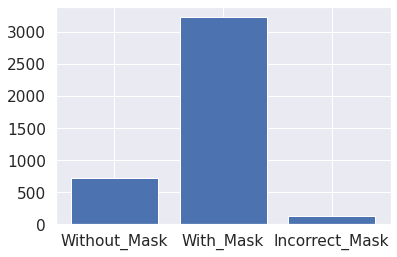

In [ ]:
#Finding count of each label
unique, counts = np.unique(face_labels, return_counts=True)
print(dict(zip(unique, counts)))
# We can see that there are 717 faces without masks,
# 3232 faces with mask and 123 faces with incorrect mask
x_axis = ['Without_Mask', 'With_Mask', 'Incorrect_Mask']
y_axis = [counts[0], counts[1], counts[2]]
plt.bar(x_axis, y_axis)
plt.show()

In [14]:
#Encode the labels in one hot encode form
lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels)
labels


array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [15]:
#Performing data augmentation.
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [16]:
#divide data into training and testing sets, training = 80 % and testing = 20%
(trainX, testX, trainY, testY) = train_test_split(face_images, labels,
	test_size=0.2, stratify=labels, random_state=42)

In [17]:
#define the hyperparamets for traing the neural network
INIT_LR = 1e-4
EPOCHS = 15
BS = 32

In [ ]:

model_1 = keras.models.Sequential([
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu', 
                        input_shape = (224, 224, 3)),
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2, padding = 'valid'),
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2, padding = 'valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 3, activation = 'softmax')
])


In [ ]:
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = keras.optimizers.Adam(),
                metrics = ['accuracy', keras.metrics.Recall()])

H = model_1.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/15
101/101 [==============================] - 156s 2s/step - loss: 0.6277 - accuracy: 0.7898 - recall: 0.7628 - val_loss: 0.5718 - val_accuracy: 0.7939 - val_recall: 0.7939
Epoch 2/15
101/101 [==============================] - 156s 2s/step - loss: 0.4795 - accuracy: 0.8078 - recall: 0.7895 - val_loss: 0.3535 - val_accuracy: 0.8896 - val_recall: 0.8883
Epoch 3/15
101/101 [==============================] - 157s 2s/step - loss: 0.2734 - accuracy: 0.9088 - recall: 0.9017 - val_loss: 0.2225 - val_accuracy: 0.9276 - val_recall: 0.9178
Epoch 4/15
101/101 [==============================] - 157s 2s/step - loss: 0.2355 - accuracy: 0.9256 - recall: 0.9160 - val_loss: 0.2361 - val_accuracy: 0.9190 - val_recall: 0.9006
Epoch 5/15
101/101 [==============================] - 157s 2s/step - loss: 0.2391 - accuracy: 0.9237 - recall: 0.9166 - val_loss: 0.2549 - val_accuracy: 0.9227 - val_recall: 0.9227
Epoch 6/15
101/101 [==============================] - 157s 2s/step - loss: 0.2334 - accuracy: 0

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       143
           1       0.94      0.97      0.96       647
           2       0.86      0.24      0.38        25

    accuracy                           0.93       815
   macro avg       0.88      0.68      0.73       815
weighted avg       0.92      0.93      0.92       815



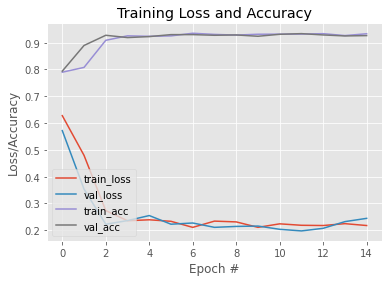

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model_1.predict(testX, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
#Plotting Confusion matrix
predY = model_1.predict(testX, batch_size = 32)
predY = np.argmax(predY, axis=1)

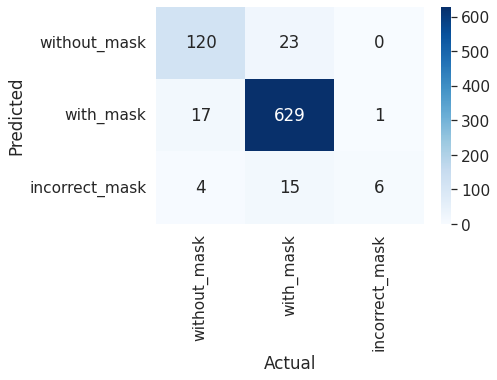

In [ ]:
cm = confusion_matrix(testY.argmax(axis=1), predY)
categories = ['without_mask', 'with_mask', 'incorrect_mask']
cm_df = pd.DataFrame(cm, categories, categories)
sn.heatmap(cm_df, annot = True, cmap = 'Blues', fmt = 'g')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [18]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
model_1.save('/content/gdrive/MyDrive/project/model_1.h5')

In [19]:
from tensorflow.keras.models import load_model
model_1=load_model('/content/gdrive/MyDrive/project/model_1.h5')

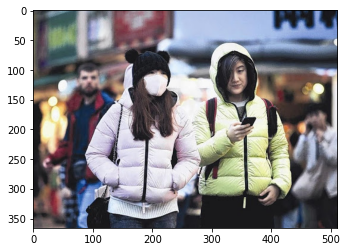

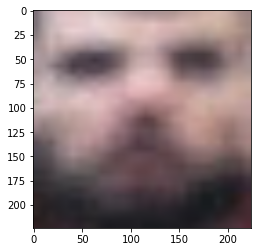

without_mask




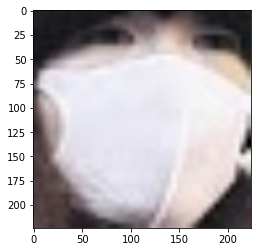

with_mask




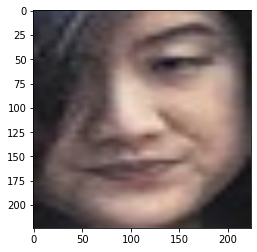

without_mask




In [22]:
# Predicting when Annotation of face is available in XML file

from skimage import transform

class_names = ['without_mask', 'with_mask', 'incorrect']

# Array of images (Here we are prediction image number 0 (first image))
image_number = [0];

for i in image_number:
  temp_img_pathh = r"images/maksssksksss{}.png".format(i)
  imggg = cv2.imread(temp_img_pathh)
  plt.grid(False)
  plt.imshow(cv2.cvtColor(imggg, cv2.COLOR_BGR2RGB))
  plt.show()
  test_images_face = []

  for j in range(number_of_faces[i]):
    locs = (targets[i]['boxes'][j])
    xx = imggg[locs[1]:locs[3],locs[0]:locs[2]]
    
    np_image = cv2.resize(xx, (224, 224))
    test_images_face.append(np_image)
  ok = 0
  for face in test_images_face:
    plt.grid(False)
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB));
    plt.show()
    face1 = img_to_array(face)
    face1 = preprocess_input(face1)
    final_image= np.array(face1, dtype="float32")/255.0

    fianl_image = transform.resize(final_image, (224, 224, 3))
    final_image = np.expand_dims(final_image, axis=0)
    predi = model_1.predict(final_image)
    ans = np.argmax(predi, axis=1)
    print(class_names[ans[0]])
    print('\n')

In [23]:
! kaggle datasets download -d lalitharajesh/haarcascades

  0% 0.00/1.45M [00:00<?, ?B/s]
100% 1.45M/1.45M [00:00<00:00, 48.3MB/s]


In [ ]:
! unzip haarcascades.zip

In [26]:
face_model = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

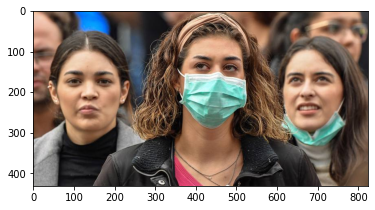

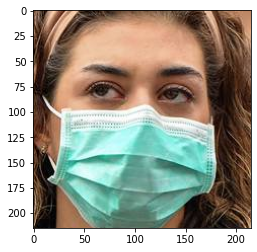

with_mask




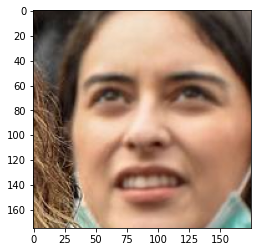

without_mask




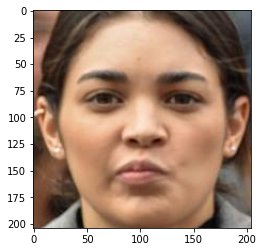

without_mask




In [29]:
#Prediction image using Cascade Calssifier

images_path = ["/content/gdrive/MyDrive/project/dataset/pic2.jpg"]
for i in images_path:
  img = cv2.imread(i)
  img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
  faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

  out_img = cv2.imread(i)
  plt.grid(False)
  plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
  plt.show()
  for (x,y,w,h) in faces:
      
      xx = out_img[y:(y + h), x:(x + w)]
      plt.grid(False)
      plt.imshow(cv2.cvtColor(xx, cv2.COLOR_BGR2RGB))
      plt.show()
      np_image = cv2.resize(xx, (224, 224))
      face = img_to_array(np_image)
      face = preprocess_input(face)
      final_image= np.array(face, dtype="float32")/255.0

      fianl_image = transform.resize(final_image, (224, 224, 3))
      final_image = np.expand_dims(final_image, axis=0)
      predi = model_1.predict(final_image)
      ans = np.argmax(predi, axis=1)
    
      print(class_names[ans[0]])
      print('\n')